# Binary Plant Segmentation models


### imports & installs

Make sure you install pytorch 2.0.X and torchvision: https://pytorch.org/get-started/locally/

In [ ]:
%pip install segmentation-models-pytorch albumentations lightning opencv-python tqdm

If you get an error with OpenCV libgl1, install following:

In [ ]:
# !sudo apt-get update && sudo apt-get install libgl1 -y

#### Restart runtime

In [1]:
#General libraries for various operations
import os
import sys
import time
# to load in notebook
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'herbarium_segmentation')))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch

from binary_models import BinaryModel
from binary_models import InferenceDataset
from binary_models import get_transforms, download_model, visualize_prediction, get_dataloader, get_train_datasets


### Inference with pretrained model

#### Load/download model
Choose from: **[unet, unetplus,deeplab]** for model names

In [ ]:
model_name = 'unetplus' # unetplus, unet, or deeplab
model_path = '../herbarium_segmentation/models/unetplus.ckpt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch device:',device)

# download or load model
model = download_model(model_path=model_path, model_name='unetplus')
model.eval()

#### Inference on Single image

Image shape: (1024, 692, 3)
Model input shape: torch.Size([3, 800, 608])


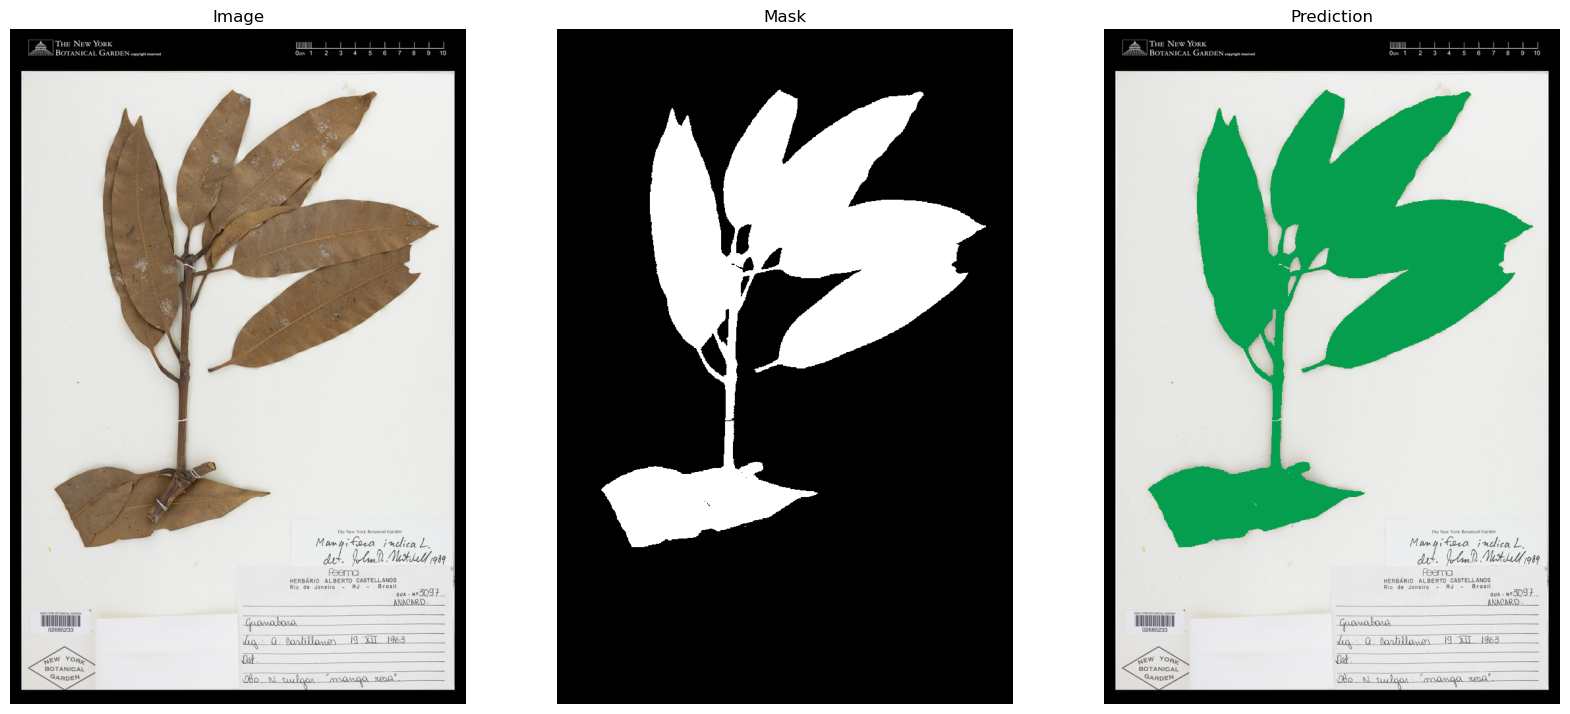

In [11]:
# Load image and convert to RGB
img_path = '../datasets/sample/img/10737.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape:', img.shape)
# get transform
_, validation_transform = get_transforms()
inputs = validation_transform(image=img)['image']
print('Model input shape:', inputs.shape)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0).to(device))

# threshold predictions
pred = (outputs > 0.5).cpu().numpy().squeeze().astype(np.uint8)

# resize prediction and show results
pred = cv2.resize(pred, img.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(20,12))
visualize_prediction(img,pred)
plt.show()

#### Inference on folder of images (batched)


In [3]:
# model was trained on normalized images
normalize = True
img_dir = '../datasets/sample/img'
img_paths = [os.path.join(img_dir,f) for f in sorted(os.listdir(img_dir)) if f.endswith('.jpg')]
print('Total images in folder:', len(img_paths))
# get transform
_, validation_transform = get_transforms()
inference_dataset = InferenceDataset(filepaths=img_paths, transform=validation_transform)

Total images in folder: 10


Check some inputs

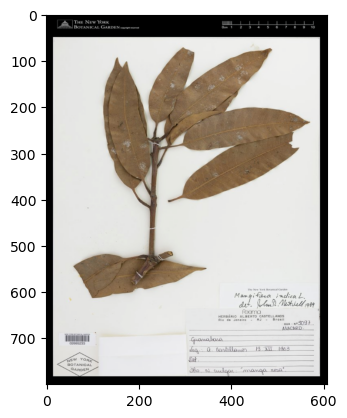

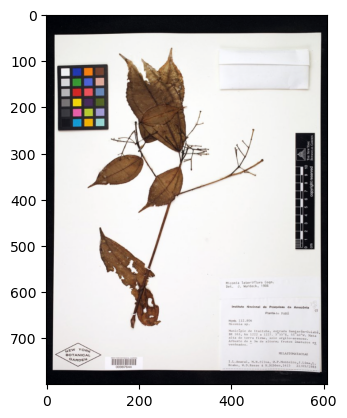

In [4]:
for i in range(2):
    img = inference_dataset[i]
    # denormalize images 
    if normalize:
        MEAN = np.array([0.485, 0.456, 0.406])
        STD = np.array([0.229, 0.224, 0.225])
        img2 = (img.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
        img2 = (img2 * 255).astype(np.uint8)
    else:
        img2 = (img.numpy()*255).astype(np.uint8)
    img2 = np.moveaxis(img2, 0, -1)
    plt.imshow(img2)
    plt.show()

Make dataloader

In [8]:
batch_size = 8
num_workers = 1

inference_dataloader = get_dataloader(inference_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

#### Inference loop

*Note: the timing and performance can probably improved.*

Starting with batch size 8 total images: 10
Saving images to: ../datasets/sample/preds


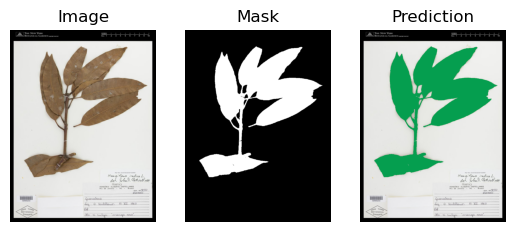

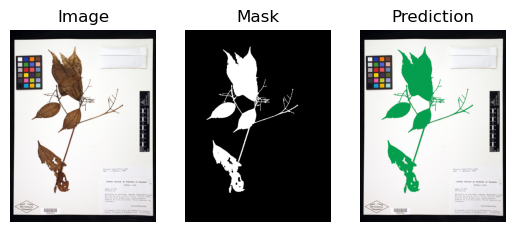

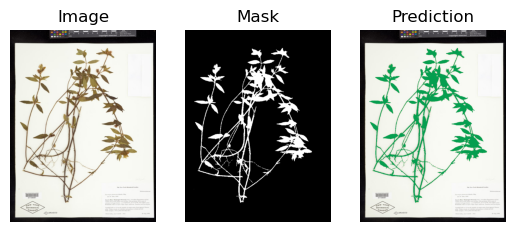

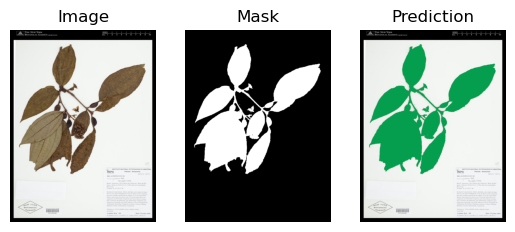

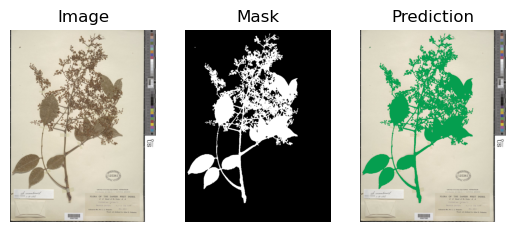

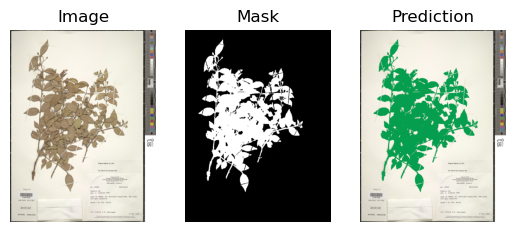

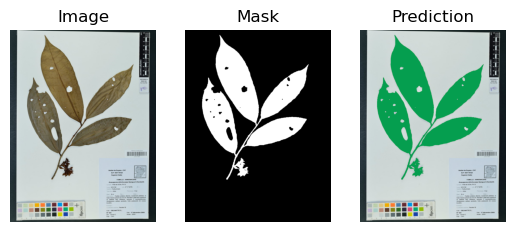

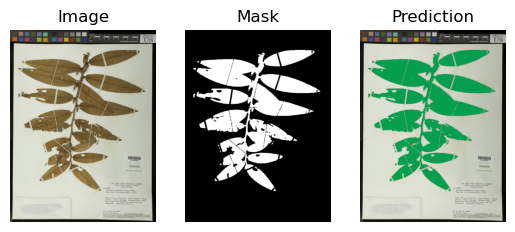

Done 0 / 1 batches, time total: 9.6 s


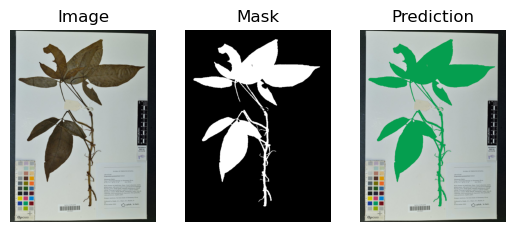

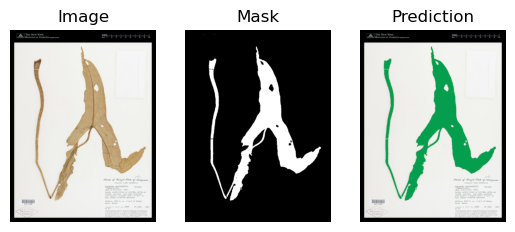

Finished in 12.2 s

Average total time/img: 719.94 ms (includes visualization)
Average model time/img: 18.83 ms
Average write time/img: 64.81 ms



In [19]:
output_dir = '../datasets/sample/preds'
os.makedirs(output_dir, exist_ok=True)

# in RGB
PLANT_COLOR = [5, 158, 79]
PRED_HEIGHT = 1024
show_results = True
# save masked prediction on original image
save_masked_pred = True
idx = 0
batch_count = 0
print('Starting with batch size',batch_size,'total images:',len(img_paths))
print('Saving images to:', output_dir)
n_batches = len(img_paths)//batch_size

# read + write time per img
times_total = []
# read 1 batch and predict
times_model = []
# resize pred to 1024 and save
times_write = []

n_plots = 2
t_initial = time.time()
for inputs in inference_dataloader:
    
    t_start = time.time()
    with torch.no_grad():
      outputs = model.model(inputs.to(device))

    outputs = (outputs > 0.5).cpu().numpy().astype(np.uint8)
    t = time.time()-t_start
    times_model.append(t)

    #outputs = cv2.resize(outputs, img.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    input_img_paths = img_paths[idx:idx+batch_size]
    write_time = 0
    for i,pred in enumerate(outputs):
        t1 = time.time()
        pred = pred.squeeze()
        pred_shape = pred.shape
        
        w = int(pred_shape[1] / (pred_shape[0]/PRED_HEIGHT)) 
        h = PRED_HEIGHT
        pred = cv2.resize(pred, (w,h), interpolation=cv2.INTER_LINEAR)
        
        if save_masked_pred or show_results:
            img = cv2.cvtColor(cv2.imread(input_img_paths[i]), cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (w,h))
            out = img.copy()
        
        _,pred = cv2.threshold(pred,0.5,1,cv2.THRESH_BINARY)
        fname = input_img_paths[i].split('/')[-1]

        if save_masked_pred:
            n_plots = 3
            out[pred.astype(bool)] = PLANT_COLOR
            out_path = os.path.join(output_dir, fname.replace('.jpg','_pred.png'))
            cv2.imwrite(out_path, cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
            
        mask_path = os.path.join(output_dir, fname.replace('.jpg','_mask.png'))
        cv2.imwrite(mask_path, pred*255)
        write_time += time.time()-t1

        if show_results:
            plt.subplot(1,n_plots,1)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Image')
            
            plt.subplot(1,n_plots,2)
            plt.imshow(pred, cmap='gray')
            plt.axis('off')
            plt.title('Mask')

            if save_masked_pred:
                plt.subplot(1,n_plots,3)
                plt.imshow(out, cmap='gray')
                plt.axis('off')
                plt.title('Prediction')
            plt.show()
    
    times_write.append(write_time)
    idx += batch_size
    t_total = time.time()-t_start
    times_total.append(t_total)
    
    if batch_count % 50 == 0:
        print('Done',batch_count,'/',n_batches,'batches, time total:',round(time.time()-t_initial,1),'s')
    batch_count += 1
    

avg_t = np.mean(times_total)
avg_t_model = np.mean(times_model)
avg_t_write = np.mean(times_write)

print('Finished in',round(time.time()-t_initial,1),'s')
print()
print('Average total time/img:',round(avg_t*1000/batch_size,2),'ms (includes visualization)')
print('Average model time/img:',round(avg_t_model*1000/batch_size,2),'ms')
print('Average write time/img:',round(avg_t_write*1000/batch_size,2),'ms')
print()

### Train on custom dataset

Split train/val images and masks into two folders. Make sure the mask filename is either equal to the image filename, but ends with .png or it ends with _plant_0.png.

Example: 
    
    image filename: 101.jpg mask filename: 101.png OR 101_plant_0.png

If you have a small dataset and it fits in memory, set load_images to True, for a big speedup. This worked on the plantclef dataset with 250 images and 16GB RAM

For full customization, define your own dataset and transforms (see binary_models.py).

In [2]:
data_dir = '../datasets/plantclef'

# image and mask folders
img_dir = os.path.join(data_dir, 'train')
mask_dir = os.path.join(data_dir, 'plant_masks_train')

img_dir_val = os.path.join(data_dir, 'val')
mask_dir_val = os.path.join(data_dir, 'plant_masks_val')

img_w = 608
img_h = 800
img_shape = (img_h, img_w)
# change to .png or .tiff if necessary for your dataset
img_extension = '.jpg'

# set to false if dataet doesn't fit in RAM
load_images = True
# images are normalized
normalize = True

train_dataset, val_dataset, image_transform, validation_transform = get_train_datasets(img_dir,
                                                                                mask_dir,
                                                                                img_dir_val,
                                                                                mask_dir_val,
                                                                                img_extension=img_extension,
                                                                                load_images=load_images,
                                                                                img_shape=img_shape)


Loading train dataset
Number of images train: 220
Loading validation dataset
Number of images validation: 30


#### Sanity check model input and augmentations

**Validation set (no augmentations)**

torch.Size([3, 800, 608]) torch.float32


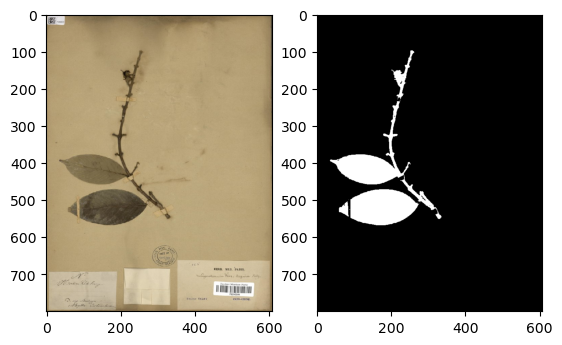

torch.Size([3, 800, 608]) torch.float32


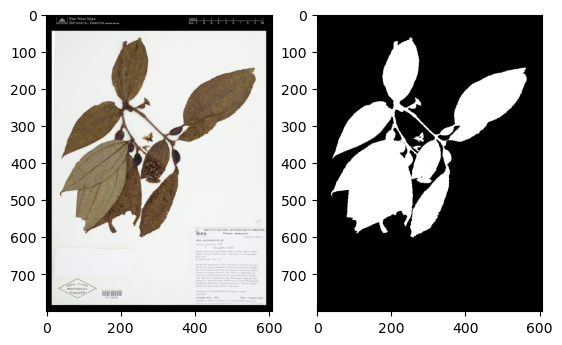

torch.Size([3, 800, 608]) torch.float32


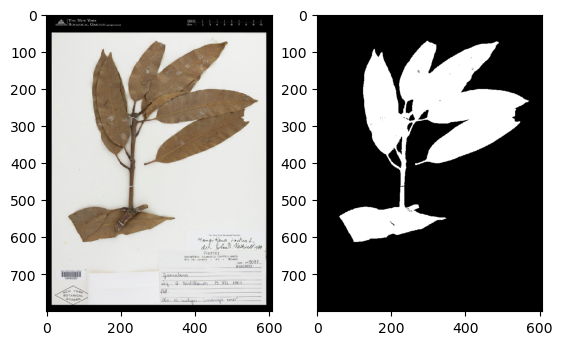

In [4]:
for i in range(3):
    img, mask = val_dataset[i]

    if normalize:
        MEAN = np.array([0.485, 0.456, 0.406])
        STD = np.array([0.229, 0.224, 0.225])
        
        img2 = (img.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
        img2 = (img2 * 255).astype(np.uint8)
    else:
        img2 = (img.numpy()*255).astype(np.uint8)
    img2 = np.moveaxis(img2, 0, -1)
    print(img.shape,img.dtype)
    
    plt.subplot(1,2,1)
    plt.imshow(img2)
    
    plt.subplot(1,2,2)
    plt.imshow(mask.numpy(), cmap='gray')
    plt.show()

**Train set (with augmentations)**

torch.Size([3, 800, 608]) torch.float32


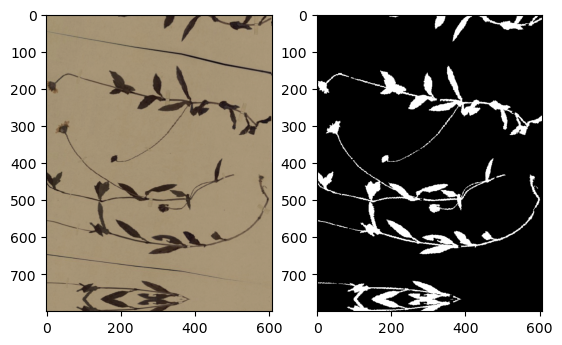

torch.Size([3, 800, 608]) torch.float32


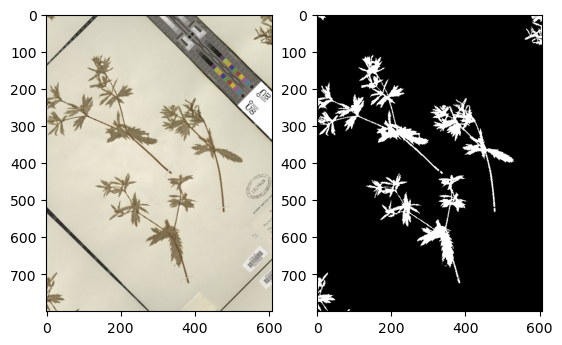

torch.Size([3, 800, 608]) torch.float32


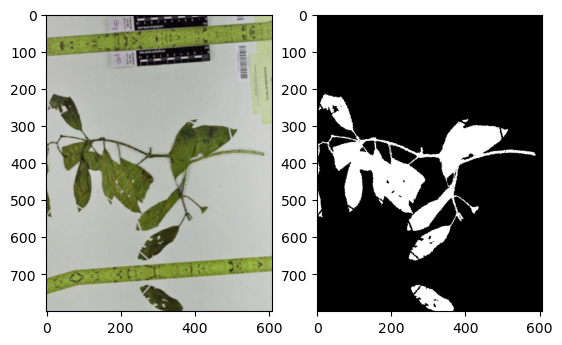

torch.Size([3, 800, 608]) torch.float32


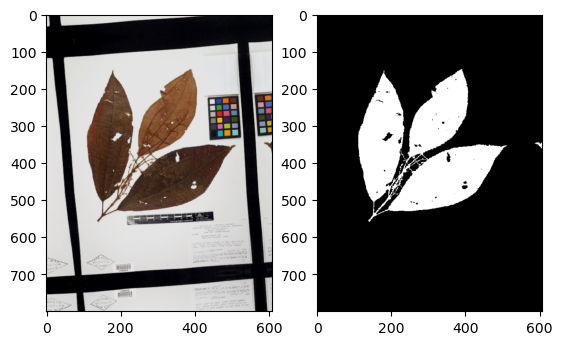

torch.Size([3, 800, 608]) torch.float32


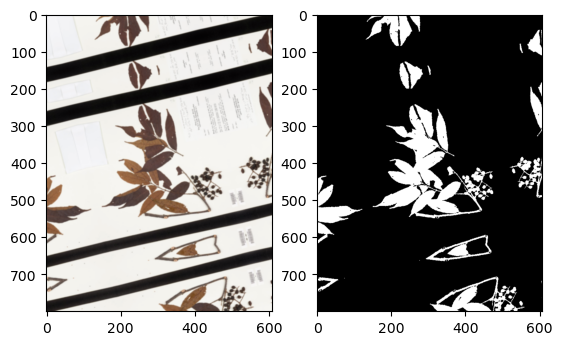

In [5]:
for i in range(5):
    img, mask = train_dataset[i]
    
    if normalize:
        MEAN = np.array([0.485, 0.456, 0.406])
        STD = np.array([0.229, 0.224, 0.225])
        
        img2 = (img.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
        img2 = (img2 * 255).astype(np.uint8)
    else:
        img2 = (img.numpy()*255).astype(np.uint8)
    img2 = np.moveaxis(img2, 0, -1)
    print(img.shape, img.dtype)
    
    plt.subplot(1,2,1)
    plt.imshow(img2)
    
    plt.subplot(1,2,2)
    plt.imshow(mask.numpy(), cmap='gray')
    plt.show()

#### Training loop (with Pytorch Lightning)

For a full list of backbones and other parameters, see: https://github.com/qubvel/segmentation_models.pytorch

In [12]:
import segmentation_models_pytorch as smp

from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint

# Define custom collate function which defines how to batch examples together
def collate_fn(batch):
    pixel_values = torch.stack([example[0] for example in batch])
    pixel_mask = torch.stack([example[1] for example in batch])

    return {"img": pixel_values, "mask": pixel_mask}

In [ ]:
# where to save the models
root_dir = '../model_weights'
os.makedirs(root_dir, exist_ok=True)

ENCODER = 'efficientnet-b0'
WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
# Binary = 1 class
CLASSES = 1

# 3 for color, 1 for grayscale
INCHANNELS = 3

BASE_MODEL = 'unetplus'

if BASE_MODEL == 'unet':
    base_model = smp.Unet(encoder_name=ENCODER, encoder_weights=WEIGHTS, in_channels=INCHANNELS, classes=CLASSES, activation=ACTIVATION)
elif BASE_MODEL == 'deeplab':
    base_model = smp.DeepLabV3Plus(encoder_name=ENCODER, encoder_weights=WEIGHTS, in_channels=INCHANNELS, classes=CLASSES, activation=ACTIVATION)
elif BASE_MODEL == 'unetplus':
    base_model = smp.UnetPlusPlus(encoder_name=ENCODER, encoder_weights=WEIGHTS, in_channels=INCHANNELS, classes=CLASSES, activation=ACTIVATION)
                                                  
model = BinaryModel(base_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch device:',device)

model_filename = f'{BASE_MODEL}_{ENCODER}_' + 'best-{epoch:02d}'
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath=root_dir,filename=model_filename, verbose=True)
num_epochs = 20
batch_size = 8
val_batch_size = 8
num_workers = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, collate_fn=collate_fn,num_workers=num_workers, pin_memory=True)

# Train the model
trainer = pl.Trainer(precision='16-mixed',accelerator='gpu',default_root_dir=root_dir, max_epochs=num_epochs, callbacks=[checkpoint_callback])
trainer.fit(model=model, train_dataloaders=train_dataloader,val_dataloaders=val_dataloader)

#### Load newly trained model and predict

In [14]:
# change to best epoch from above
epoch = '17'

model_filename = f'{BASE_MODEL}_{ENCODER}_best-epoch={epoch}.ckpt'
print('Loading model:',model_filename)


model = BinaryModel.load_from_checkpoint(os.path.join(root_dir,model_filename),model=base_model)
model.eval()

Loading model: unetplus_efficientnet-b0_best-epoch=17.ckpt


BinaryModel(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding

In [15]:
def f1_score(pred, label):
    intersection = cv2.countNonZero(cv2.bitwise_and(pred, label))
    area = cv2.countNonZero(pred) + cv2.countNonZero(label)
    return (intersection*2.0) / area

def iou_score(pred, label):
    intersection = cv2.bitwise_and(pred, label)
    union = cv2.bitwise_or(pred, label)

    return cv2.countNonZero(intersection) / cv2.countNonZero(union)

### Results on validation set

In [18]:
# make sure the ordering is the same as in the validation set
# which should normally be the case
val_img_filenames = os.listdir(img_dir_val)

Label shape: (1024, 669) output shape (1024, 669)
0 Iou: 0.886 f1 0.94


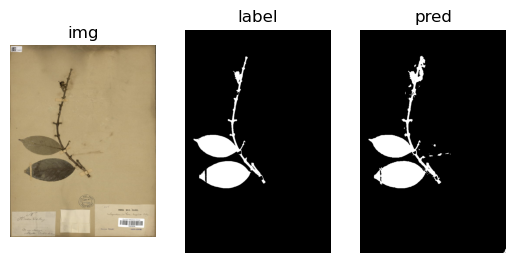

Label shape: (1024, 698) output shape (1024, 698)
1 Iou: 0.985 f1 0.992


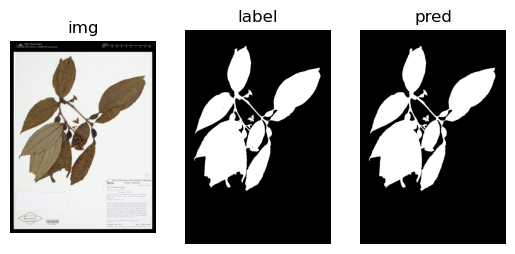

Label shape: (1024, 692) output shape (1024, 692)
2 Iou: 0.983 f1 0.991


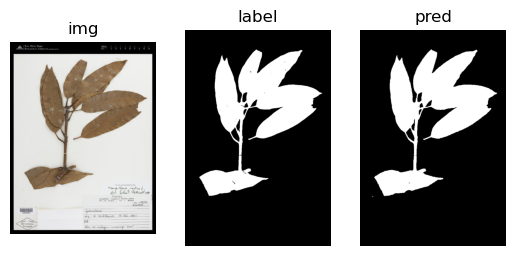

Label shape: (1024, 683) output shape (1024, 683)
3 Iou: 0.955 f1 0.977


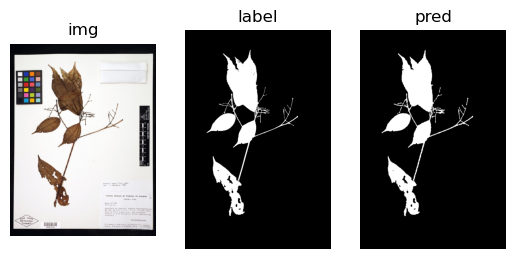

Label shape: (1024, 659) output shape (1024, 659)
4 Iou: 0.857 f1 0.923


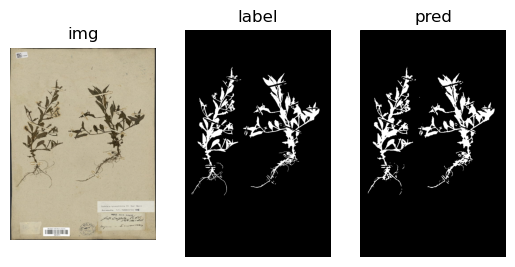

Label shape: (1024, 873) output shape (1024, 873)
5 Iou: 0.895 f1 0.945


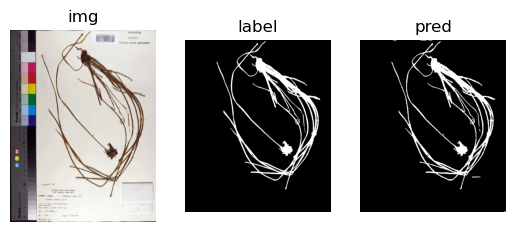

Label shape: (1024, 683) output shape (1024, 683)
6 Iou: 0.956 f1 0.978


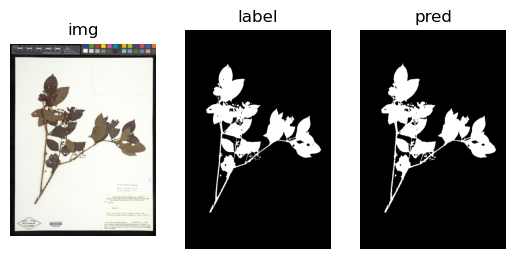

Label shape: (1024, 703) output shape (1024, 703)
7 Iou: 0.835 f1 0.91


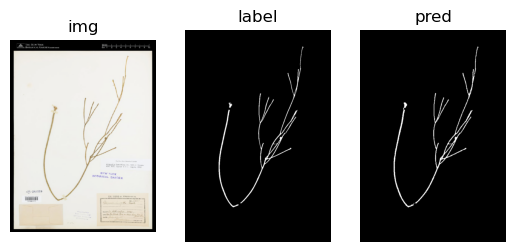

Label shape: (1024, 657) output shape (1024, 657)
8 Iou: 0.957 f1 0.978


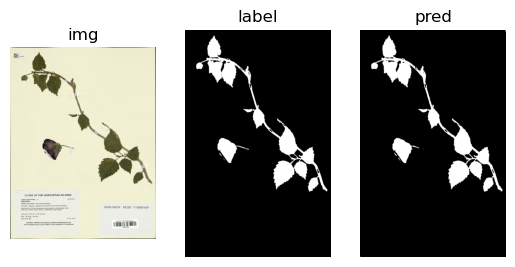

Label shape: (1024, 769) output shape (1024, 769)
9 Iou: 0.932 f1 0.965


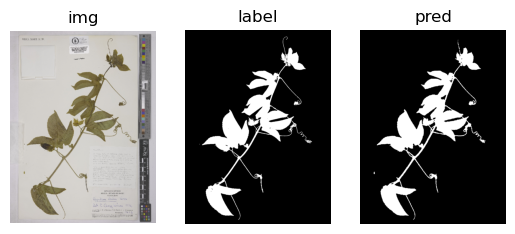

Label shape: (1024, 776) output shape (1024, 776)
10 Iou: 0.982 f1 0.991


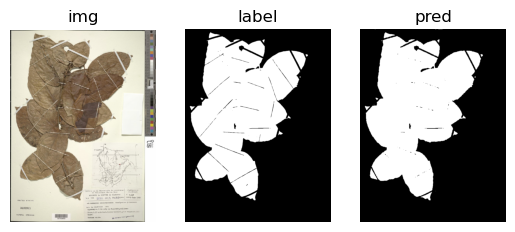

Label shape: (1024, 683) output shape (1024, 683)
11 Iou: 0.871 f1 0.931


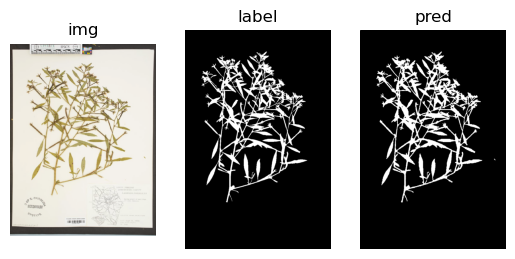

Label shape: (1024, 779) output shape (1024, 779)
12 Iou: 0.924 f1 0.961


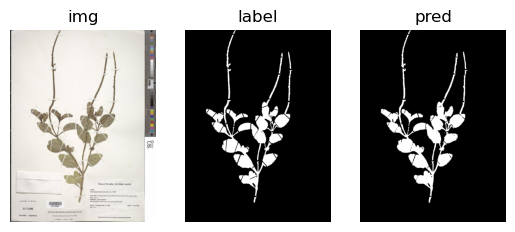

Label shape: (1024, 683) output shape (1024, 683)
13 Iou: 0.986 f1 0.993


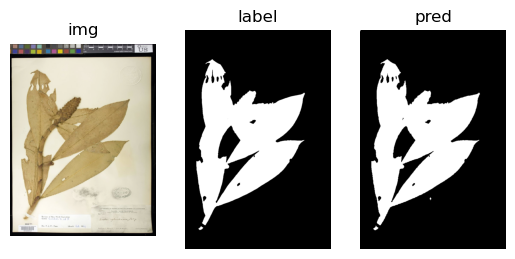

Label shape: (1024, 683) output shape (1024, 683)
14 Iou: 0.974 f1 0.987


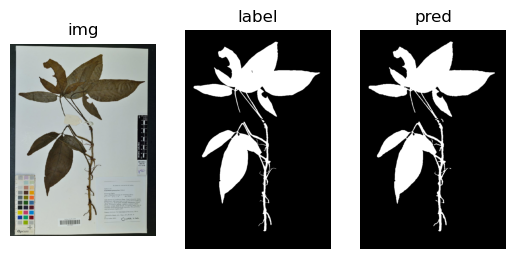

Label shape: (1024, 779) output shape (1024, 779)
15 Iou: 0.896 f1 0.945


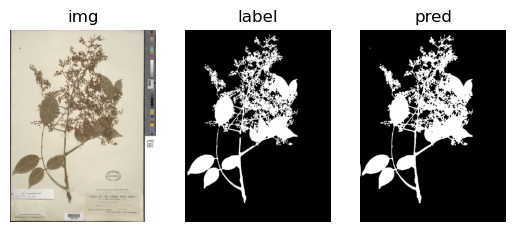

Label shape: (1024, 755) output shape (1024, 755)
16 Iou: 0.873 f1 0.932


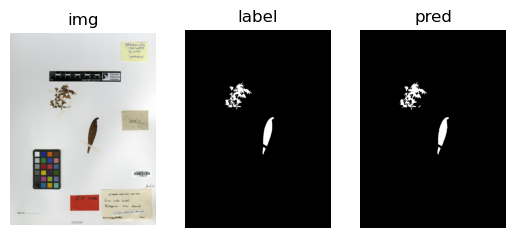

Label shape: (1024, 687) output shape (1024, 687)
17 Iou: 0.98 f1 0.99


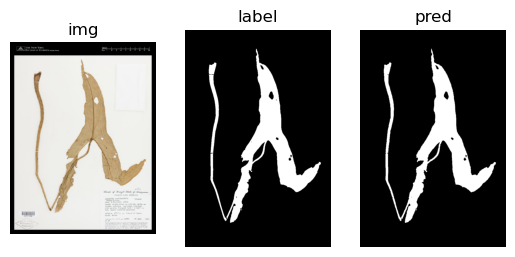

Label shape: (1024, 683) output shape (1024, 683)
18 Iou: 0.976 f1 0.988


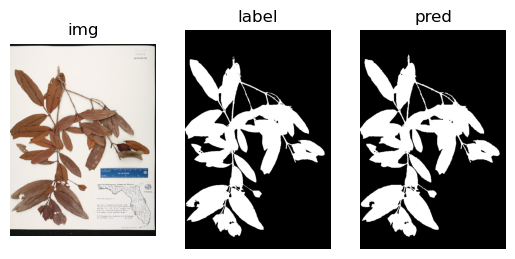

Label shape: (1024, 683) output shape (1024, 683)
19 Iou: 0.972 f1 0.986


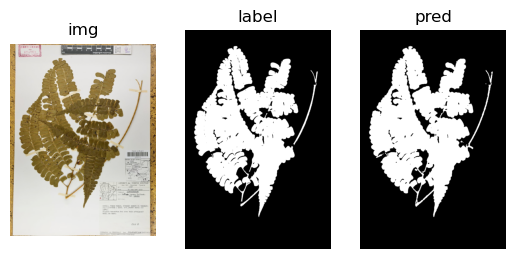

Label shape: (1024, 683) output shape (1024, 683)
20 Iou: 0.956 f1 0.977


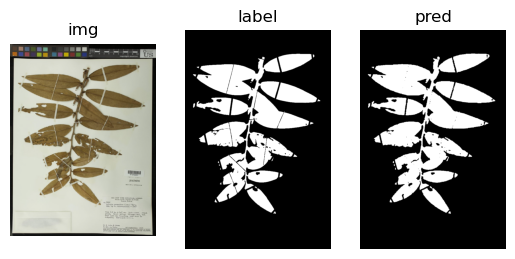

Label shape: (1024, 660) output shape (1024, 660)
21 Iou: 0.972 f1 0.986


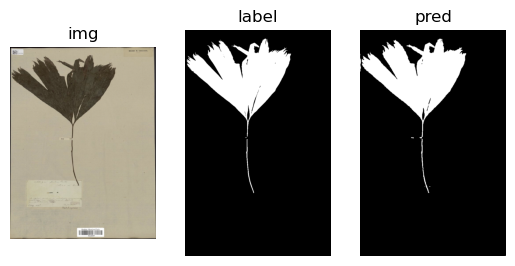

Label shape: (1024, 692) output shape (1024, 692)
22 Iou: 0.938 f1 0.968


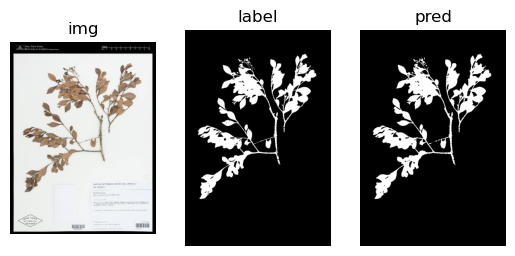

Label shape: (1024, 683) output shape (1024, 683)
23 Iou: 0.984 f1 0.992


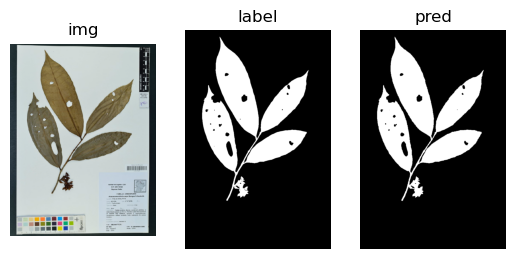

Label shape: (1024, 773) output shape (1024, 773)
24 Iou: 0.984 f1 0.992


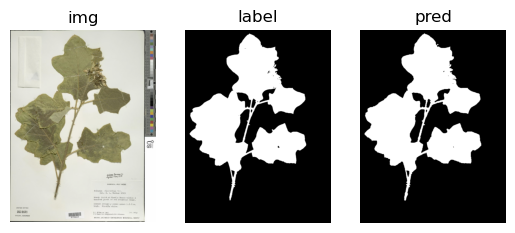

Label shape: (1024, 778) output shape (1024, 778)
25 Iou: 0.965 f1 0.982


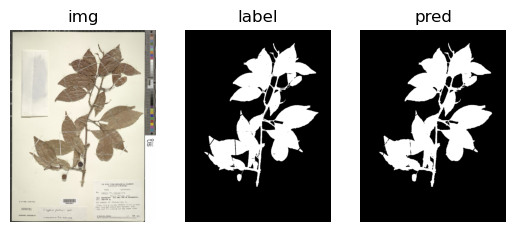

Label shape: (1024, 778) output shape (1024, 778)
26 Iou: 0.943 f1 0.971


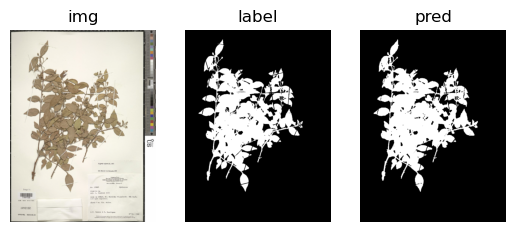

Label shape: (1024, 883) output shape (1024, 883)
27 Iou: 0.898 f1 0.947


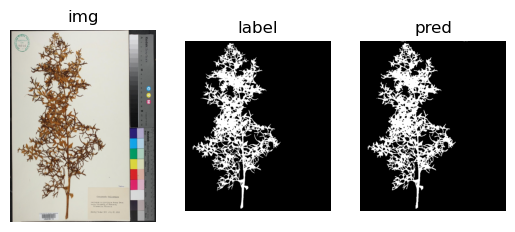

Label shape: (1024, 695) output shape (1024, 695)
28 Iou: 0.985 f1 0.992


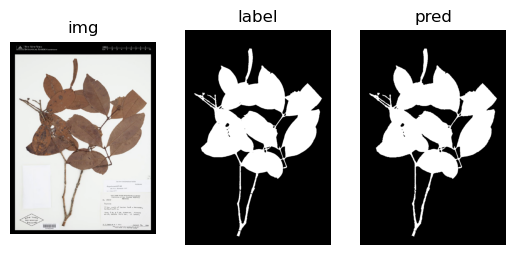

Label shape: (1024, 683) output shape (1024, 683)
29 Iou: 0.886 f1 0.94


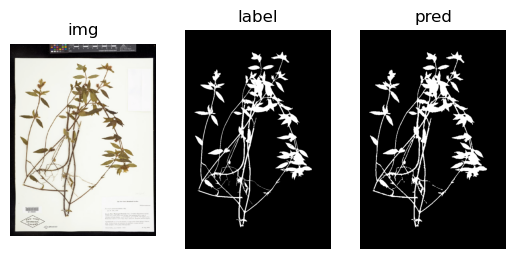

IoU for validation set: 0.9395082306182108
F1 for validation set: 0.9682495366086521
All IoU scores: [0.8347450980392157, 0.8568359674696946, 0.8712088776773627, 0.8726044744617982, 0.8860865185813497, 0.8862658227848101, 0.8954027274664393, 0.8960998910804037, 0.8984499260540781, 0.9241504342693313, 0.932430808667441, 0.9383769523498238, 0.9427974026133291, 0.9545799715234932, 0.9556966072040967, 0.9560207345833236, 0.9566187581262958, 0.9648359788991977, 0.9716050715393221, 0.9720470390033583, 0.9735370673864842, 0.9758031177557183, 0.9800885966114079, 0.9819756454289987, 0.982666559876123, 0.9841315067485903, 0.9843069987666747, 0.9847378212636946, 0.9848585625415704, 0.9862819797728923]


In [22]:
import pickle

all_results = []
iou_scores = []
f1_scores = []

show_results = True

for i in range(len(val_dataset)):

    image,label = val_dataset[i]
    with torch.no_grad():
      outputs = model.model(image.unsqueeze(0).to(device)).squeeze().squeeze()
    outputs = (outputs > 0.5).cpu().numpy().astype(np.uint8)
    
    img_filename = val_img_filenames[i]
    label_path1 = os.path.join(mask_dir_val, img_filename.replace(img_extension, "_plant_0.png"))
    label_path2 = os.path.join(mask_dir_val, img_filename.replace(img_extension, ".png"))
    
    if os.path.exists(label_path1):
        label_path = label_path1
    elif os.path.exists(label_path1):
        label_path = label_path1
    else:
        print("No mask found for image:", img_filename)
        continue
    
    label = cv2.imread(label_path,0)
    outputs = cv2.resize(outputs, label.shape[::-1], interpolation=cv2.INTER_LINEAR)
    _, outputs = cv2.threshold(outputs,0.5,1,cv2.THRESH_BINARY)
    
    print('Label shape:',label.shape,'output shape',outputs.shape)
    if normalize:
        MEAN = np.array([0.485, 0.456, 0.406])
        STD = np.array([0.229, 0.224, 0.225])
        
        img2 = (image.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
        img2 = (img2 * 255).astype(np.uint8)
    else:
        img2 = (image.numpy()*255).astype(np.uint8)
    
    img2 = np.moveaxis(img2, 0, -1)
    f1 = f1_score(outputs, label)
    iou = iou_score(outputs, label)
    print(i,'Iou:',round(iou,3),'f1',round(f1,3))
    
    iou_scores.append(iou)
    f1_scores.append(f1)
    all_results.append({'img_filename':img_filename, 'mask':outputs})
    if show_results:
        plt.subplot(1,3,1)
        plt.imshow(img2)
        plt.axis('off')
        plt.title('img')
        
        plt.subplot(1,3,2)
        plt.imshow(label, cmap='gray')
        plt.axis('off')
        plt.title('label')
    
        plt.subplot(1,3,3)
        plt.imshow(outputs, cmap='gray')
        plt.axis('off')
        plt.title('pred')
        plt.show()


print('IoU for validation set:',np.mean(iou_scores))
print('F1 for validation set:',np.mean(f1_scores))
print('All IoU scores:', sorted(iou_scores))

#### Convert predictions to COCO format and save

Note: you will need any dataset in COCO format for this to work properly

In [ ]:
%pip install pycocotools

In [28]:
import json
import pycocotools.mask as mask_utils

# any dataset will do, just need image id and filenames in there
gt_json_path = os.path.join(data_dir, 'objects_val_rle_split.json')

filename2id = {}

with open(gt_json_path,'r') as f:
  gt_anns = json.load(f)

for i in gt_anns['images']:

  fname = i['file_name'].replace('.jpg','')
  filename2id[fname] = i['id']

In [29]:
predictions_dir = os.path.join(data_dir, 'predictions')
os.makedirs(predictions_dir, exist_ok=True)

mask_annos = []
plant_category_id = 1

for m in all_results:

    mask = m['mask']
    fname = m['img_filename']
    image_id = filename2id[fname.replace('.jpg','')]
    rle = mask_utils.encode(np.asfortranarray(mask))

    # create output dictionary
    rle_dict = {'counts': rle['counts'].decode('utf-8'), 'size': list(rle['size'])}

    mask_annos.append({'image_id':image_id, 'category_id':plant_category_id,'segmentation':rle_dict})
    
sem_seg_path = os.path.join(predictions_dir, 'unetplus_coco_preds.json')
with open(sem_seg_path,'w') as f:
    json.dump(mask_annos, f)